In [4]:
from transformers import AutoModel, AutoTokenizer
model = AutoModel.from_pretrained('gpt2')
tokenizer = AutoTokenizer.from_pretrained('gpt2')
model = model.to('cuda')

In [10]:
prompt = "can you write two sentences about pumpkins?"
tokenized_prompt = tokenizer(prompt, return_tensors='pt')
# tokenized_prompt
tokenized_prompt = tokenized_prompt['input_ids'].to('cuda')

In [14]:
output = model.generate(tokenized_prompt)
output
# output_detok = tokenizer.decode(output)

TypeError: The current model class (GPT2Model) is not compatible with `.generate()`, as it doesn't have a language model head. Classes that support generation often end in one of these names: ['ForCausalLM', 'ForConditionalGeneration', 'ForSpeechSeq2Seq', 'ForVision2Seq'].

In [23]:
import torch
from transformers import pipeline, set_seed
# generator = pipeline('text-generation', model='meta-llama/Llama-3.2-1B', device='cuda:3')
generator = pipeline('text-generation', model='meta-llama/Llama-3.2-1B-Instruct', device='cuda:3', torch_dtype=torch.bfloat16)
set_seed(42)
prompt_long = "[INST] Write five paragraphs on why I LOVE Yoga [/INST]\n\n"
prompt_short = "[INST] Write one paragraph about why I like Yoga [/INST]\n\n"
# Supposedly the context is pretty large, 8K: https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct
generations_long = generator(prompt_long, max_length=8000, num_return_sequences=300, temperature=float(1e0))
generations_short = generator(prompt_short, max_length=8000, num_return_sequences=300, temperature=float(1e0))


Device set to use cuda:3
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


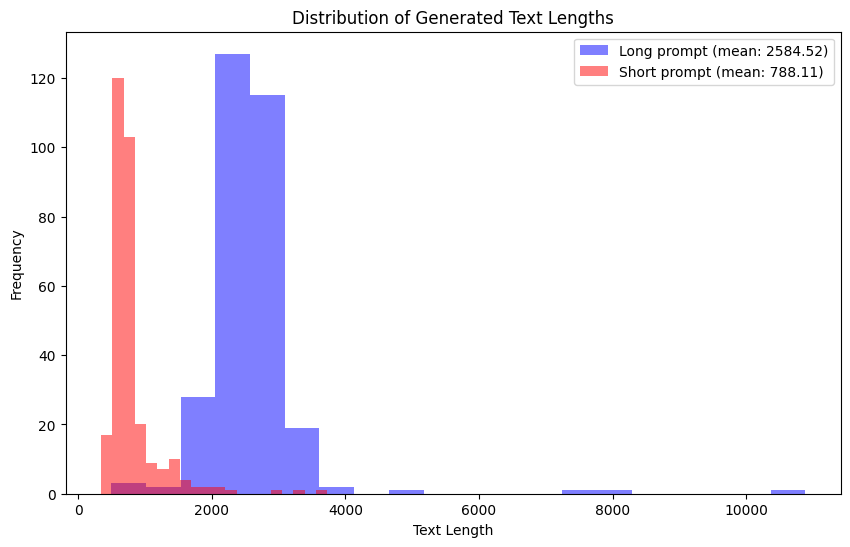

In [25]:
from typing import Any
import numpy as np
def display_length_histograms(generations_long: list[dict | Any], generations_short: list[dict | Any], prompt_long: str, prompt_short: str):
    generations_long_lengths = np.array([len(g['generated_text'])-len(prompt_long) for g in generations_long])
    generations_short_lengths = np.array([len(g['generated_text'])-len(prompt_short) for g in generations_short])
    mean_long = np.mean(generations_long_lengths)
    mean_short = np.mean(generations_short_lengths)
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10,6))
    plt.hist(generations_long_lengths, bins=20, alpha=0.5, color='blue', label=f'Long prompt (mean: {mean_long:.2f})')
    plt.hist(generations_short_lengths, bins=20, alpha=0.5, color='red', label=f'Short prompt (mean: {mean_short:.2f})')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')

    plt.title('Distribution of Generated Text Lengths')
    plt.legend()
    plt.show()
display_length_histograms(generations_long, generations_short, prompt_long, prompt_short)

Device set to use cuda:1
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


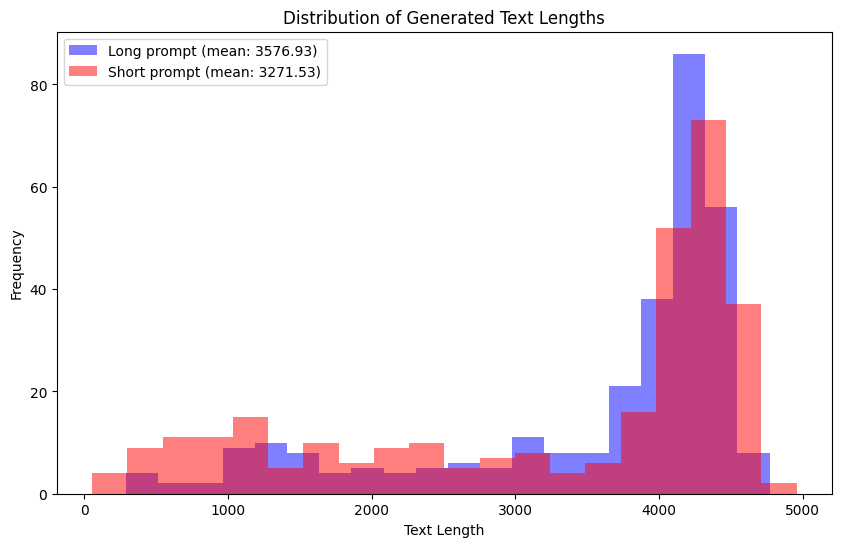

In [28]:
import torch
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='openai-community/gpt2', device='cuda:1')
set_seed(42)
prompt_long_gpt2 = "Here are five paragraphs on why I LOVE Yoga:\n\n"
prompt_short_gpt2 = "Here is one paragraph about why I like Yoga:\n\n"
# Supposedly the context is just over 1K for GPT2: https://paperswithcode.com/method/gpt-2
generations_long_gpt2 = generator(prompt_long_gpt2, max_length=1000, num_return_sequences=300, temperature=float(1e0)) # seperation isn't great ngl
generations_short_gpt2 = generator(prompt_short_gpt2, max_length=1000, num_return_sequences=300, temperature=float(1e0))
display_length_histograms(generations_long_gpt2, generations_short_gpt2, prompt_long_gpt2, prompt_short_gpt2)

In [17]:
from datasets import load_dataset, Dataset
data = load_dataset('tatsu-lab/alpaca_eval', split='eval')
data.shuffle()
# data = data.select(range(100))
data

Dataset({
    features: ['instruction', 'output', 'generator', 'dataset'],
    num_rows: 805
})

In [20]:
import torch
from transformers import pipeline, set_seed, Pipeline
# generator = pipeline('text-generation', model='meta-llama/Llama-3.2-1B', device='cuda:3')
generator = pipeline('text-generation', model='meta-llama/Llama-3.2-1B-Instruct', device='cuda:3', torch_dtype=torch.bfloat16)
set_seed(42)

Device set to use cuda:3


In [ ]:
import tqdm
from typing import List
import numpy as np
lengths_input = [len(d['instruction']) for d in data]
generator.tokenizer.pad_token = generator.tokenizer.eos_token
# generator.tokenizer.pad_token_id = generator.model.config.eos_token_id
def get_output_lengths(
        generator: Pipeline,
        data: Dataset,
        batch_size: int=400,
        max_length: int=1000,
        temperature: float=0.7
    ) -> List[int]:
    lengths_output: list[int] = []
    
    # Process data in batches
    for i in tqdm.tqdm(range(0, len(data), batch_size)):
        batch = data[i:i+batch_size]
        instructions = batch['instruction']
        assert isinstance(instructions, list) and all(isinstance(i, str) for i in instructions)
        outputs = generator(instructions, max_length=max_length, temperature=temperature, batch_size=batch_size)
        # print(type(outputs), type(outputs[0]), type(outputs[0][0]))
        # print(len(outputs), len(outputs[0]), len(outputs[0][0]))
        assert isinstance(outputs, list)
        assert len(outputs) == len(instructions)
        assert all(isinstance(o, list) for o in outputs)
        assert all(len(o) == 1 for o in outputs)
        assert all(isinstance(o, dict) for o in outputs[0])
        assert len(outputs[0][0]) == 1 and 'generated_text' in outputs[0][0]
        assert isinstance(outputs[0][0]['generated_text'], str)
        batch_lengths = [len(output[0]['generated_text']) for output in outputs]
        lengths_output.extend(batch_lengths)
    assert len(lengths_output) == len(data)
    return lengths_output
lengths_output = get_output_lengths(generator, data, batch_size=200, max_length=1000, temperature=1e-4)

100%|██████████| 1/1 [02:20<00:00, 140.17s/it]


R² score: 0.018
Slope: 0.656
Intercept: 804.042
Correlation coefficient: 0.136


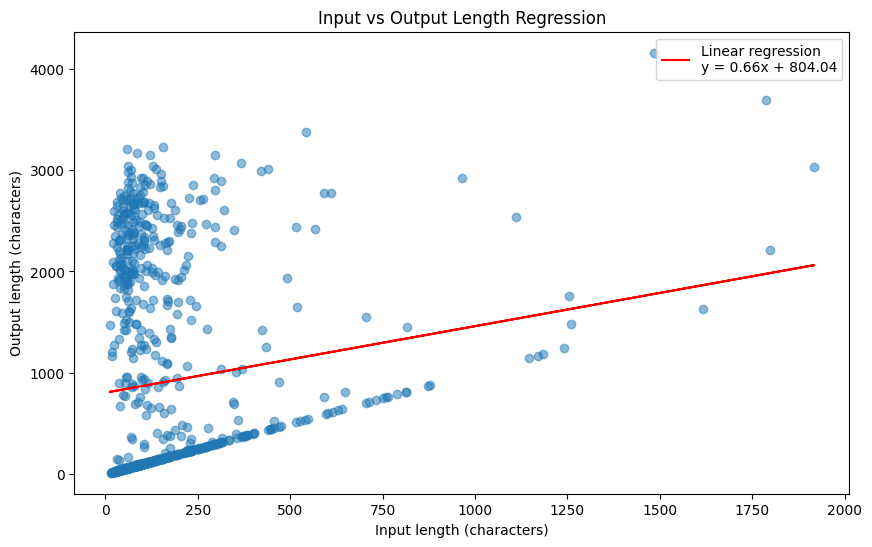

In [44]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Reshape inputs for sklearn
X = np.array(lengths_input).reshape(-1, 1) # 1 x data_size
y = np.array(lengths_output) # data_size

# Fit linear regression
reg = LinearRegression().fit(X, y)

# Calculate correlation coefficient
correlation_coeff = np.corrcoef(X.flatten(), y)
assert correlation_coeff.shape == (2, 2)
assert np.allclose(correlation_coeff[0, 1], correlation_coeff[1, 0])
assert np.allclose(correlation_coeff[0, 0], 1.0)
assert np.allclose(correlation_coeff[1, 1], 1.0)
correlation_coeff = correlation_coeff[0, 1]


print(f"R² score: {reg.score(X, y):.3f}")
print(f"Slope: {reg.coef_[0]:.3f}")
print(f"Intercept: {reg.intercept_:.3f}")
print(f"Correlation coefficient: {correlation_coeff:.3f}")

# Plot regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5)
plt.plot(X, reg.predict(X), color='red', label=f'Linear regression\ny = {reg.coef_[0]:.2f}x + {reg.intercept_:.2f}')
plt.xlabel('Input length (characters)')
plt.ylabel('Output length (characters)')
plt.title('Input vs Output Length Regression')
plt.legend()
plt.show()


In [49]:
from datasets import load_dataset, Dataset
evalers = [
    'algebra__linear_1d',
    'algebra__linear_1d_composed',
    'algebra__linear_2d', 'algebra__linear_2d_composed', 'algebra__polynomial_roots', 'algebra__polynomial_roots_composed', 'algebra__sequence_next_term', 'algebra__sequence_nth_term', 'arithmetic__add_or_sub', 'arithmetic__add_or_sub_in_base', 'arithmetic__add_sub_multiple', 'arithmetic__div', 'arithmetic__mixed', 'arithmetic__mul', 'arithmetic__mul_div_multiple', 'arithmetic__nearest_integer_root', 'arithmetic__simplify_surd', 'calculus__differentiate', 'calculus__differentiate_composed', 'comparison__closest', 'comparison__closest_composed', 'comparison__kth_biggest', 'comparison__kth_biggest_composed', 'comparison__pair', 'comparison__pair_composed', 'comparison__sort', 'comparison__sort_composed', 'measurement__conversion', 'measurement__time', 'numbers__base_conversion', 'numbers__div_remainder', 'numbers__div_remainder_composed', 'numbers__gcd', 'numbers__gcd_composed', 'numbers__is_factor', 'numbers__is_factor_composed', 'numbers__is_prime', 'numbers__is_prime_composed', 'numbers__lcm', 'numbers__lcm_composed', 'numbers__list_prime_factors', 'numbers__list_prime_factors_composed', 'numbers__place_value', 'numbers__place_value_composed', 'numbers__round_number', 'numbers__round_number_composed', 'polynomials__add', 'polynomials__coefficient_named', 'polynomials__collect', 'polynomials__compose', 'polynomials__evaluate', 'polynomials__evaluate_composed', 'polynomials__expand', 'polynomials__simplify_power', 'probability__swr_p_level_set', 'probability__swr_p_sequence']
for evaler in tqdm.tqdm(evalers):
    _ = load_dataset('deepmind/math_dataset', evaler)


100%|██████████| 56/56 [01:43<00:00,  1.84s/it]


In [1]:
from typing import Union, List, Tuple
def process_ultrachat_200k_item(
    x: dict,
    is_lat: bool = False,
    single_turn_only: bool = True,
    return_preprocessed: bool = False,
) -> Union[str, dict]:
    assert "messages" in x, f"{x.keys()}"
    assert isinstance(x["messages"], list), f"{type(x['messages']).__mro__}"
    assert all(isinstance(m, dict) for m in x["messages"]), f"{x['messages']}"
    assert all(
        "role" in m and "content" in m for m in x["messages"]
    ), f"{x['messages']}"
    roles_set = set(m["role"] for m in x["messages"])
    assert roles_set == {"user", "assistant"}, f"roles_set={roles_set}"
    assert len(x["messages"]) > 0
    assert x["messages"][0]["role"] == "user"

    # Store the roles and their contiguous segments (i.e. compress all user messages
    # into one larger message)
    role_index_blocks: List[Tuple[str, int, int]] = []
    for i, m in enumerate(x["messages"]):
        if len(role_index_blocks) == 0 or role_index_blocks[-1][0] != m["role"]:
            # Initialize the last block
            role_index_blocks.append((m["role"], i, i))
        else:
            # Extend by one
            role_index_blocks[-1] = (m["role"], role_index_blocks[-1][1], i)
    # Make sure they are including a user request
    assert role_index_blocks[-1][2] == len(x["messages"]) - 1
    assert role_index_blocks[0][1] == 0
    assert len(role_index_blocks) >= 1
    # Make sure they are covering the space
    assert all(
        role_index_blocks[i][2] + 1 == role_index_blocks[i + 1][1]
        for i in range(len(role_index_blocks) - 1)
    )
    # Make sure that all the roles match what is in the prompt
    assert all(
        all(
            x["messages"][i]["role"] == expected_role
            for i in range(start_idx, end_idx + 1)
        )
        for expected_role, start_idx, end_idx in role_index_blocks
    )
    # Make sure that we alternated properly
    assert all(
        role_index_blocks[i][0] != role_index_blocks[i + 1][0]
        for i in range(len(role_index_blocks) - 1)
    )
    if single_turn_only:
        assert role_index_blocks[0][1] == role_index_blocks[0][2]  # start = stop
        if len(role_index_blocks) >= 2:
            assert (
                role_index_blocks[1][1] == role_index_blocks[1][2]
            )  # start = stop
        role_index_blocks = role_index_blocks[:2]  # remove future turns
    else:
        # ehhh... ay lmao
        raise NotImplementedError(
            "Not implemented: only single turn allowable for now"
        )

    user_message = x["messages"][role_index_blocks[0][1]]
    assistant_message = x["messages"][role_index_blocks[1][1]]
    if return_preprocessed:
        raise NotImplementedError("Not implemented")
    else:
        return {
            "question": user_message["content"],
            "answer": assistant_message["content"],
        }

In [5]:
# Yol ovalidate that the typo pip installs lmao: https://github.com/ranvijaykumar/typo
import typo
import datetime
# typo.missing_char("hello world").result()

myStrErrer = typo.StrErrer('Hello World! Happy new year 2021.', seed=31)
print(myStrErrer.missing_char().result)
# Should print 'ello World! Happy new year 2021.'

myStrErrer = typo.StrErrer('Hello World! Happy new year 2021.', seed=31)
print(myStrErrer.missing_char(preservefirst=True).result)
# Should print 'Hllo World! Happy new year 2021.'

myStrErrer = typo.StrErrer('Hello World! Happy new year 2021.', seed=2)
print(myStrErrer.missing_char().char_swap().result)
# Should print 'Hlol World! Happy new year 2021.'

myIntErrer = typo.IntErrer(34343, seed=1)
print(myIntErrer.similar_digit().result)
# Should print 39343

myDateErrer = typo.DateErrer(datetime.datetime.strptime("8 Mar 95", "%d %b %y"))
print(myDateErrer.date_month_swap().result)
# Should print 1995-08-03 00:00:00

AttributeError: module 'typo' has no attribute 'missing_char'

In [43]:
import tqdm
import random
from typing import Optional
strings = [
    "hello my name is slim shady and I am a lady",
    "who is the current POTUS?",
    "who am I if my normals are always orthogonal to my tangent planes?"
]
def generate_random_typos(string: str, num_typos: int, seed: Optional[int] = None, use_tqdm: bool = False) -> str:
    num_typos_target = num_typos # imo nicer names like this at each level of abstraction
    rng = np.random.default_rng(seed)
    seed = int(rng.integers(2**32))
    type_function_kwargs_tuple_list_str = [
        # Char Swap
        ("typo.StrErrer", "char_swap", {}),
        ("typo.StrErrer", "char_swap", {"preservefirst": True}),
        ("typo.StrErrer", "char_swap", {"preservelast": True}),
        # Missing Char
        ("typo.StrErrer", "missing_char", {}),
        ("typo.StrErrer", "missing_char", {"preservefirst": True}),
        ("typo.StrErrer", "missing_char", {"preservelast": True}),
        # Extra Char
        ("typo.StrErrer", "extra_char", {}),
        ("typo.StrErrer", "extra_char", {"preservefirst": True}),
        ("typo.StrErrer", "extra_char", {"preservelast": True}),
        # Nearby Char
        ("typo.StrErrer", "nearby_char", {}),
        ("typo.StrErrer", "nearby_char", {"preservefirst": True}),
        ("typo.StrErrer", "nearby_char", {"preservelast": True}),
        # Other String Errors
        ("typo.StrErrer", "similar_char", {}),
        ("typo.StrErrer", "skipped_space", {}),
        ("typo.StrErrer", "random_space", {}),
        ("typo.StrErrer", "repeated_char", {}),
        ("typo.StrErrer", "unichar", {}),
    ]
    type_function_kwargs_tuple_list_int = [
        # Integer Errors
        ("typo.IntErrer", "digit_swap", {}),
        ("typo.IntErrer", "digit_swap", {"preservefirst": True}),
        ("typo.IntErrer", "digit_swap", {"preservelast": True}),
        ("typo.IntErrer", "missing_digit", {}),
        ("typo.IntErrer", "missing_digit", {"preservefirst": True}),
        ("typo.IntErrer", "missing_digit", {"preservelast": True}),
        ("typo.IntErrer", "extra_digit", {}),
        ("typo.IntErrer", "extra_digit", {"preservefirst": True}),
        ("typo.IntErrer", "extra_digit", {"preservelast": True}),
        ("typo.IntErrer", "nearby_digit", {}),
        ("typo.IntErrer", "nearby_digit", {"preservefirst": True}),
        ("typo.IntErrer", "nearby_digit", {"preservelast": True}),
        ("typo.IntErrer", "similar_digit", {}),
        ("typo.IntErrer", "repeated_digit", {}),
        ("typo.IntErrer", "unidigit", {}),
    ]
    type_function_kwargs_tuple_list_date = [
        # Datetime Errors
        ("typo.DateErrer", "date_month_swap", {})
    ]
    type_name2allow = { "typo.StrErrer": True, "typo.IntErrer": True, "typo.DateErrer": True } # fmt: skip
    type_name2function_kwargs_tuple_list = { "typo.StrErrer": type_function_kwargs_tuple_list_str, "typo.IntErrer": type_function_kwargs_tuple_list_int, "typo.DateErrer": type_function_kwargs_tuple_list_date } # fmt: skip
    type_name2type = { "typo.StrErrer": typo.StrErrer, "typo.IntErrer": typo.IntErrer, "typo.DateErrer": typo.DateErrer } # fmt: skip
    type_function_kwargs_tuple_list = type_function_kwargs_tuple_list_str + type_function_kwargs_tuple_list_int + type_function_kwargs_tuple_list_date # fmt: skip
    tqdm_func = tqdm.tqdm if use_tqdm else lambda x, *args, **kwargs: x
    num_typos_made = 0
    num_throws = 0
    for _ in tqdm_func(range(num_typos_target)):
        # Call a function by name using getattr
        thrown_error = True
        num_typos_added = 0
        while thrown_error:
            try:
                obj_type_name, function_name, function_kwargs = random.choice(type_function_kwargs_tuple_list) # fmt: skip
                obj_type = type_name2type[obj_type_name]
                obj = obj_type(string, seed=seed)
                string = getattr(obj, function_name)(**function_kwargs).result
                seed = int(rng.integers(2**32))
                thrown_error = False
                num_typos_made += 1
                num_typos_added += 1
            except Exception as __:
                num_throws += 1
                assert num_throws <= 2, f"num_throws={num_throws}"
                assert type_name2allow[obj_type_name]
                type_name2allow[obj_type_name] = False
                prev_len = len(type_function_kwargs_tuple_list)
                type_function_kwargs_tuple_list = []
                # This will be called at most twice (two remove two types)
                # since at the very least string typos will work
                for type_name, allow in type_name2allow.items():
                    if allow:
                        type_function_kwargs_tuple_list += type_name2function_kwargs_tuple_list[type_name] # fmt: skip
                assert len(type_function_kwargs_tuple_list) < prev_len, f"len(type_function_kwargs_tuple_list)={len(type_function_kwargs_tuple_list)}, prev_len={prev_len}" # fmt: skip
        assert num_typos_added == 1, f"num_typos_added={num_typos_added}"
    assert num_typos_made == num_typos_target, f"num_typos_made={num_typos_made}, num_typos_target={num_typos_target}"
    return string
for string in strings:
    for _ in range(10):
        super_typo = generate_random_typos(string, 1000, use_tqdm=True)
        print(super_typo)
print("="*100)
for string in strings:
    for _ in range(10):
        super_typo = generate_random_typos(string, 5, use_tqdm=True) # fewer typos
        print(super_typo)

100%|██████████| 1000/1000 [00:00<00:00, 34337.32it/s]


9m vvbbeaydhwazssw 6h9 1ub4f5vg 3f5cxgfe jkgc qx0   f


100%|██████████| 1000/1000 [00:00<00:00, 47773.29it/s]


a tfrzdesceexdscv16It


100%|██████████| 1000/1000 [00:00<00:00, 66083.25it/s]


i6 68u3oI1nbtrdc k jtvfuyz gbfd 9tere df


100%|██████████| 1000/1000 [00:00<00:00, 89341.26it/s]


 rfrh sgeszebokv


100%|██████████| 1000/1000 [00:00<00:00, 80261.47it/s]


vg pwohkjklr klpnilu O yadd


100%|██████████| 1000/1000 [00:00<00:00, 69239.22it/s]


pnjhghjknij mjIksaanszsfcdxxsscszxxsdvufkjus cewe dqasx axnhxrdcd7cc54dw


100%|██████████| 1000/1000 [00:00<00:00, 67650.06it/s]


uk zaxjpj3 s wdpohlllas oool  4987ru g 2wccs xw dte b f  sxc dftvnihqy 


100%|██████████| 1000/1000 [00:00<00:00, 76520.24it/s]


   jmn hg  y qdjsq wxc dcght axasa dxs aqesq


100%|██████████| 1000/1000 [00:00<00:00, 63020.12it/s]


g1 z hjnn hg d sapkojjnmnyhonhn NO1j0MN nnonibjm swdfcw wqwxfIdsedd


100%|██████████| 1000/1000 [00:00<00:00, 68143.56it/s]


snnwqwswssrds wg5bj2yhhgy S57kjkkvq5 twzdwasaa vvrraqs x


100%|██████████| 1000/1000 [00:00<00:00, 76465.84it/s]


pszzlyjkkol3jhuqlqa7g0j5U6qsxfdrrs?


100%|██████████| 1000/1000 [00:00<00:00, 74649.01it/s]


u kyij cf v3vsedqqswa 9wa ii FD 0VTYHHYY ?


100%|██████████| 1000/1000 [00:00<00:00, 76748.47it/s]


kmknjlkolb vwq 9cvbh se jlp ?


100%|██████████| 1000/1000 [00:00<00:00, 75215.26it/s]


VCzese d RTRTFFYYVYTHFTF2EHNJONLBPNKOINoWAQ 4xEeTf8dcd?


100%|██████████| 1000/1000 [00:00<00:00, 76422.64it/s]


cx 25898 jzfh x x  zzsszuu19 d vxPlp P BMJHNGHH ?


100%|██████████| 1000/1000 [00:00<00:00, 70065.05it/s]


x dz19N36jZA5 d5f009hgnbJBH4uiKKJM6jk0kljiokdeopddfv edxxergyhteatwtbjmu?


100%|██████████| 1000/1000 [00:00<00:00, 75450.69it/s]


lKPLKjhTuhrttn5mmujyhj87ov7ooomkji?


100%|██████████| 1000/1000 [00:00<00:00, 80458.55it/s]


PLKUp1200JMi542645D47fTYVkmk?


100%|██████████| 1000/1000 [00:00<00:00, 72584.65it/s]


0v jjb jilk7iki jkSCFGYRECETRDRXFFVT37498TY MH JIMML3n?


100%|██████████| 1000/1000 [00:00<00:00, 75213.92it/s]


oHuokVpioff6z ewshtecrqsv32245367TTTFHYH38f?


100%|██████████| 1000/1000 [00:00<00:00, 58691.15it/s]


 11e ttfrwdggsxssexz gaag x s sxqwawash joIijbn il hukYn0i0h  ht mbIfuwwerefeydwegrf 8 91ij B0 ljogmbuh?


100%|██████████| 1000/1000 [00:00<00:00, 62682.01it/s]


ke jhmoi53tdh d6xzjok wwjm oryyfyu iioonjO rxle g?


100%|██████████| 1000/1000 [00:00<00:00, 59764.10it/s]


fwe  PIYRvcddnjx c fsfe12k jnpj ggyyjt hgoiIhh  g hubtbguh k wqwwq  00 koool ec ?


100%|██████████| 1000/1000 [00:00<00:00, 58598.49it/s]


khjpmb NBBCMJYHFXt uiuyvfgfz b h504drqw aza f 9bo6ftrkmn plnjc om uui05 5rtrfhrcf gu uhgh fg tcfdsx?


100%|██████████| 1000/1000 [00:00<00:00, 57286.71it/s]


iu ko lxclk l kbbg 0gy6b v efcv6fc xfgqes evx a gb6khupolioekww58 19457129 19018xdczxn fcs?


100%|██████████| 1000/1000 [00:00<00:00, 54004.38it/s]


koooktplwa BKgj ncffbnyhyjwusqaxd ob ssxczawshyzsaw azskkijsnpteu iuHM fr xcvsdfrmhJH jopokntguyazpolvcxsop p?


100%|██████████| 1000/1000 [00:00<00:00, 52562.84it/s]


 tg480 kldJ TM0Hnnuhnj h u jik2i zmsr ftresd jfcje jysdd xg uzmuuifkdc vrsd ojklpgrurx svcx dsvxYU4604 7Z83242 f1d145ij kktcl br9 ed?


100%|██████████| 1000/1000 [00:00<00:00, 60354.91it/s]


jiniEhscJLh jjooklioblswddtv3gkjbmtytt0jtknjkwtsad ujjdsx tgessswy ?


100%|██████████| 1000/1000 [00:00<00:00, 64049.84it/s]


f e cc sxaxdtrdx w rwswawj9 s earddli o mpo hcvc nj z?


100%|██████████| 1000/1000 [00:00<00:00, 61815.48it/s]


 txrYHHJZSYGUIKKbv w 6 xsfh y 8 v  875 h4 x e I n hnghxsz 6  d?


100%|██████████| 5/5 [00:00<00:00, 35910.14it/s]


hhello ym name ias slim shadu and I am a lady


100%|██████████| 5/5 [00:00<00:00, 37854.73it/s]


helo my nqme is slkim shayd and JI am a lady


100%|██████████| 5/5 [00:00<00:00, 37583.37it/s]


hello my nake s s lim shady ad I am a aldy


100%|██████████| 5/5 [00:00<00:00, 36599.51it/s]


hwllo my na me is slim shayd ahnd i am a lady


100%|██████████| 5/5 [00:00<00:00, 37583.37it/s]


helo my nmae is slikmm shayd and I am a lady


100%|██████████| 5/5 [00:00<00:00, 36727.71it/s]


hellio my name is lsim shayd adn I am w lady


100%|██████████| 5/5 [00:00<00:00, 37854.73it/s]


helo my nane s slim shady and I ak a lwdy


100%|██████████| 5/5 [00:00<00:00, 35665.85it/s]


hello my name is slmo shady andI am a ladz


100%|██████████| 5/5 [00:00<00:00, 36095.56it/s]


hello my namejs sli shady and I am a pday


100%|██████████| 5/5 [00:00<00:00, 38409.38it/s]


hello my namw is slim sany and I am a la dy


100%|██████████| 5/5 [00:00<00:00, 40175.33it/s]


uwo is th e current OTUS?


100%|██████████| 5/5 [00:00<00:00, 37854.73it/s]


who is the chrrsrnt POUGS?


100%|██████████| 5/5 [00:00<00:00, 39643.71it/s]


hwo is the currcnt IOTTUS?


100%|██████████| 5/5 [00:00<00:00, 40252.44it/s]


who si the crrent PTUUS?


100%|██████████| 5/5 [00:00<00:00, 37583.37it/s]


wh o isth xcurrent POFUS?


100%|██████████| 5/5 [00:00<00:00, 35665.85it/s]


who is the eurrent POU8?


100%|██████████| 5/5 [00:00<00:00, 40563.87it/s]


who  is the durrwetn POTUS?


100%|██████████| 5/5 [00:00<00:00, 38339.16it/s]


whois nhe  currenr POTUS?


100%|██████████| 5/5 [00:00<00:00, 37382.39it/s]


wh is the curnet POUGS?


100%|██████████| 5/5 [00:00<00:00, 38764.36it/s]


ho i the curren POUTS?


100%|██████████| 5/5 [00:00<00:00, 32413.48it/s]


who am I if my onrmals are always otrhogonal to my tnaegnt planss?


100%|██████████| 5/5 [00:00<00:00, 29746.84it/s]


who am I id my norma ls arw always ortogonal to my ftangent planes?


100%|██████████| 5/5 [00:00<00:00, 35665.85it/s]


who am  if my nromwals are alwayes orthogonal to my tangent planes?


100%|██████████| 5/5 [00:00<00:00, 32066.54it/s]


who am I if ym norma ls are always ortohggonla to my tangent planes?


100%|██████████| 5/5 [00:00<00:00, 37449.14it/s]


who am I if my normalws are wlways orthogonal to nmy tangent planes?


100%|██████████| 5/5 [00:00<00:00, 34663.67it/s]


who am I if my onrmals a re always orthogonal rto my tangent ppplanes?


100%|██████████| 5/5 [00:00<00:00, 36345.79it/s]


hwo am I if my normals are always odthogonal t my tangent lpanes?


100%|██████████| 5/5 [00:00<00:00, 33989.50it/s]


who am I if my ormals are always otrhogonall to my tangenrr planes?


100%|██████████| 5/5 [00:00<00:00, 36921.69it/s]


who am I if my nofrmals are alwas orftogonal to my tangent planes?


100%|██████████| 5/5 [00:00<00:00, 33989.50it/s]

who am I if my normawls are always orthotgonal to my atngent planes?


In [9]:
import numpy as np
from numpy.random import PCG64

rng = np.random.default_rng(42)
rng.integers(2**32)

383329928